In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import time
import warnings
warnings.filterwarnings('ignore')

# Configuration for performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')



In [ ]:
start_total = time.time()

# Load data
test = "/content/test-00000-of-00001-44110b9df98c5585.parquet"
train = "/content/train-00000-of-00001-c08a401c53fe5312.parquet"

df_train = pd.read_parquet(train)
df_test = pd.read_parquet(test)


In [ ]:
# Original image processing function
def dict_to_image(image_dict):
    """Image processing with same dimensions"""
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        img = img.astype(np.float32) / 255.0
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")


In [ ]:
# Process images with timing
print("📷 Processing images (128x128 grayscale)...")
img_start = time.time()
df_train['img_arr'] = df_train['image'].apply(dict_to_image)
df_train.drop("image", axis=1, inplace=True)
img_time = time.time() - img_start
print(f"✅ Image processing: {img_time:.2f}s")


📷 Processing images (128x128 grayscale)...
✅ Image processing: 0.57s


In [ ]:
# Label mapping
label_mapping = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}
df_train['class_name'] = df_train['label'].map(label_mapping)

# Data split
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['class_name'], random_state=42)
print(f"📊 Data split - Train: {len(train_df)}, Val: {len(val_df)}")


📊 Data split - Train: 4096, Val: 1024


In [ ]:
# Prepare data
X_train = np.stack(train_df['img_arr'].values)
y_train = train_df['label'].values
X_val = np.stack(val_df['img_arr'].values)
y_val = val_df['label'].values

# Reshape X
X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)

print(f"📈 Data shapes - Train: {X_train.shape}, Val: {X_val.shape}")


📈 Data shapes - Train: (4096, 128, 128, 1), Val: (1024, 128, 128, 1)


In [ ]:
# IMPROVED CNN Model with dropout to reduce overfitting
def create_improved_cnn_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dropout(0.15),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(4, activation='softmax', dtype='float32')
    ])
    return model

print("🏗️ Building improved CNN model with dropout...")
model_start = time.time()
model = create_improved_cnn_model()

optimizer = Adam(learning_rate=0.0008)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_time = time.time() - model_start
print(f"✅ Model creation: {model_time:.2f}s")


🏗️ Building improved CNN model with dropout...
✅ Model creation: 0.05s


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    min_delta=0.0009
)

print("\n📋 Improved Model Architecture Summary:")
model.summary()

print("\n🔥 Starting training (improved configuration)...")
train_start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

train_time = time.time() - train_start
print(f"✅ Training completed: {train_time:.2f}s")



📋 Improved Model Architecture Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       401,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,868 (1.62 MB)

 Trainable params: 424,868 (1.62 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Starting training (improved configuration)...
Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4533 - loss: 1.0933 - val_accuracy: 0.5615 - val_loss: 0.9543
Epoch 2/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5371 - loss: 0.9734 - val_accuracy: 0.5918 - val_loss: 0.8839
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5759 - loss: 0.8854 - val_accuracy: 0.6396 - val_loss: 0.8043
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6215 - loss: 0.8097 - val_accuracy: 0.6904 - val_loss: 0.6969
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6917 - loss: 0.7063 - val_accuracy: 0.7461 - val_loss: 0.6306
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7236 - loss: 0.6046 - val_accuracy: 0.7646 - val_loss: 0.5774
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7735 - loss: 0.5209 - val_accuracy: 0.8174 - val_loss: 0.4744
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step -

In [ ]:
# Validation evaluation
eval_start = time.time()
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
val_accuracy = accuracy_score(y_val, y_pred)
eval_time = time.time() - eval_start
print(f"✅ Validation evaluation: {eval_time:.2f}s")

# Test set evaluation
print("📊 Evaluating on test set...")
test_start = time.time()
df_test['img_arr'] = df_test['image'].apply(dict_to_image)
X_test = np.stack(df_test['img_arr'].values)
X_test = X_test.reshape(-1, 128, 128, 1)
y_test = df_test['label'].values
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_time = time.time() - test_start
print(f"✅ Test evaluation: {test_time:.2f}s")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Validation evaluation: 0.80s
📊 Evaluating on test set...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Test evaluation: 0.52s


In [ ]:
train_acc = max(history.history['accuracy'])
val_acc = max(history.history['val_accuracy'])
overfitting_gap = train_acc - val_acc
total_time = time.time() - start_total

print("\n🎯 IMPROVED CNN RESULTS" + "="*38)
print(f"📊 Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"📊 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📉 Overfitting Gap: {overfitting_gap:.4f} ({overfitting_gap*100:.2f}%)")
print(f"⏱️ Total Execution Time: {total_time:.2f} seconds")
print(f"🎯 Overfitting Reduction:")
print(f"   {'✅ GOOD' if overfitting_gap < 0.05 else '⚠️ MODERATE' if overfitting_gap < 0.10 else '❌ HIGH'} - Gap: {overfitting_gap*100:.1f}%")



🎯 IMPROVED CNN RESULTS======================================
📊 Validation Accuracy: 0.9697 (96.97%)
📊 Test Accuracy: 0.9555 (95.55%)
📉 Overfitting Gap: 0.0117 (1.17%)
⏱️ Total Execution Time: 995.99 seconds
🎯 Overfitting Reduction:
   ✅ GOOD - Gap: 1.2%


In [ ]:
# Classification reports
print("\n📊 DETAILED CLASSIFICATION REPORTS" + "="*30)
print("\n🔍 VALIDATION SET RESULTS:")
print(classification_report(y_val, y_pred, target_names=list(label_mapping.values())))
print("\n🔍 TEST SET RESULTS:")
print(classification_report(y_test, y_test_pred, target_names=list(label_mapping.values())))



📊 DETAILED CLASSIFICATION REPORTS==============================

🔍 VALIDATION SET RESULTS:
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.94      0.96       145
 Moderate_Demented       1.00      0.90      0.95        10
      Non_Demented       0.97      0.98      0.97       513
Very_Mild_Demented       0.97      0.96      0.97       356

          accuracy                           0.97      1024
         macro avg       0.98      0.95      0.96      1024
      weighted avg       0.97      0.97      0.97      1024


🔍 TEST SET RESULTS:
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.90      0.94       172
 Moderate_Demented       1.00      0.80      0.89        15
      Non_Demented       0.96      0.98      0.97       634
Very_Mild_Demented       0.94      0.95      0.95       459

          accuracy                           0.96      1280
         macro avg       0.97      0.91   

In [ ]:
# Overfitting analysis
print("\n🔍 OVERFITTING ANALYSIS" + "="*35)
print(f"📈 Best Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"📊 Best Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"📉 Overfitting Gap: {overfitting_gap:.4f} ({overfitting_gap*100:.2f}%)")

if overfitting_gap < 0.03:
    print("✅ EXCELLENT: Very low overfitting!")
elif overfitting_gap < 0.05:
    print("👍 GOOD: Minimal overfitting")
elif overfitting_gap < 0.08:
    print("⚠️ MODERATE: Some overfitting present")
else:
    print("❌ HIGH: Significant overfitting detected")

# Summary of improvements
print("\n🛡️ OVERFITTING REDUCTION TECHNIQUES APPLIED" + "="*20)
print("✅ Dropout Layer 1: 20% after Flatten layer")
print("✅ Dropout Layer 2: 30% before output layer")
print("✅ Reduced Dense Layer: 64 → 32 neurons")
print("✅ Lower Learning Rate: 0.001 → 0.0008")
print("✅ Enhanced Early Stopping: patience=7, min_delta=0.001")
print("✅ Mixed Precision: Enabled for efficiency")

# Final performance
print("\n🎯 FINAL PERFORMANCE SUMMARY" + "="*30)
print(f"🏆 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🛡️ Overfitting Reduction: {overfitting_gap*100:.1f}% gap")
print(f"🚀 Training Epochs: {len(history.history['accuracy'])} (early stopped)")
print(f"⏱️ Total Time: {total_time:.1f} seconds")
print(f"📊 Model Parameters: {model.count_params():,}")

# Recommendations
print("\n💡 RECOMMENDATIONS" + "="*40)
if overfitting_gap < 0.05:
    print("🌟 Model shows good generalization!")
    print("   → Consider slight architecture expansion if accuracy needs improvement")
else:
    print("📈 For further overfitting reduction:")
    print("   → Add data augmentation (rotation, zoom, brightness)")
    print("   → Consider batch normalization after Conv2D layers")
    print("   → Experiment with L1/L2 regularization")
    print("   → Try reducing model capacity further")
print("="*70)



🔍 OVERFITTING ANALYSIS===================================
📈 Best Training Accuracy: 0.9814 (98.14%)
📊 Best Validation Accuracy: 0.9697 (96.97%)
📉 Overfitting Gap: 0.0117 (1.17%)
✅ EXCELLENT: Very low overfitting!

🛡️ OVERFITTING REDUCTION TECHNIQUES APPLIED====================
✅ Dropout Layer 1: 20% after Flatten layer
✅ Dropout Layer 2: 30% before output layer
✅ Reduced Dense Layer: 64 → 32 neurons
✅ Lower Learning Rate: 0.001 → 0.0008
✅ Enhanced Early Stopping: patience=7, min_delta=0.001
✅ Mixed Precision: Enabled for efficiency

🎯 FINAL PERFORMANCE SUMMARY==============================
🏆 Test Accuracy: 0.9555 (95.55%)
🛡️ Overfitting Reduction: 1.2% gap
🚀 Training Epochs: 37 (early stopped)
⏱️ Total Time: 996.0 seconds
📊 Model Parameters: 424,868

💡 RECOMMENDATIONS========================================
🌟 Model shows good generalization!
   → Consider slight architecture expansion if accuracy needs improvement


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


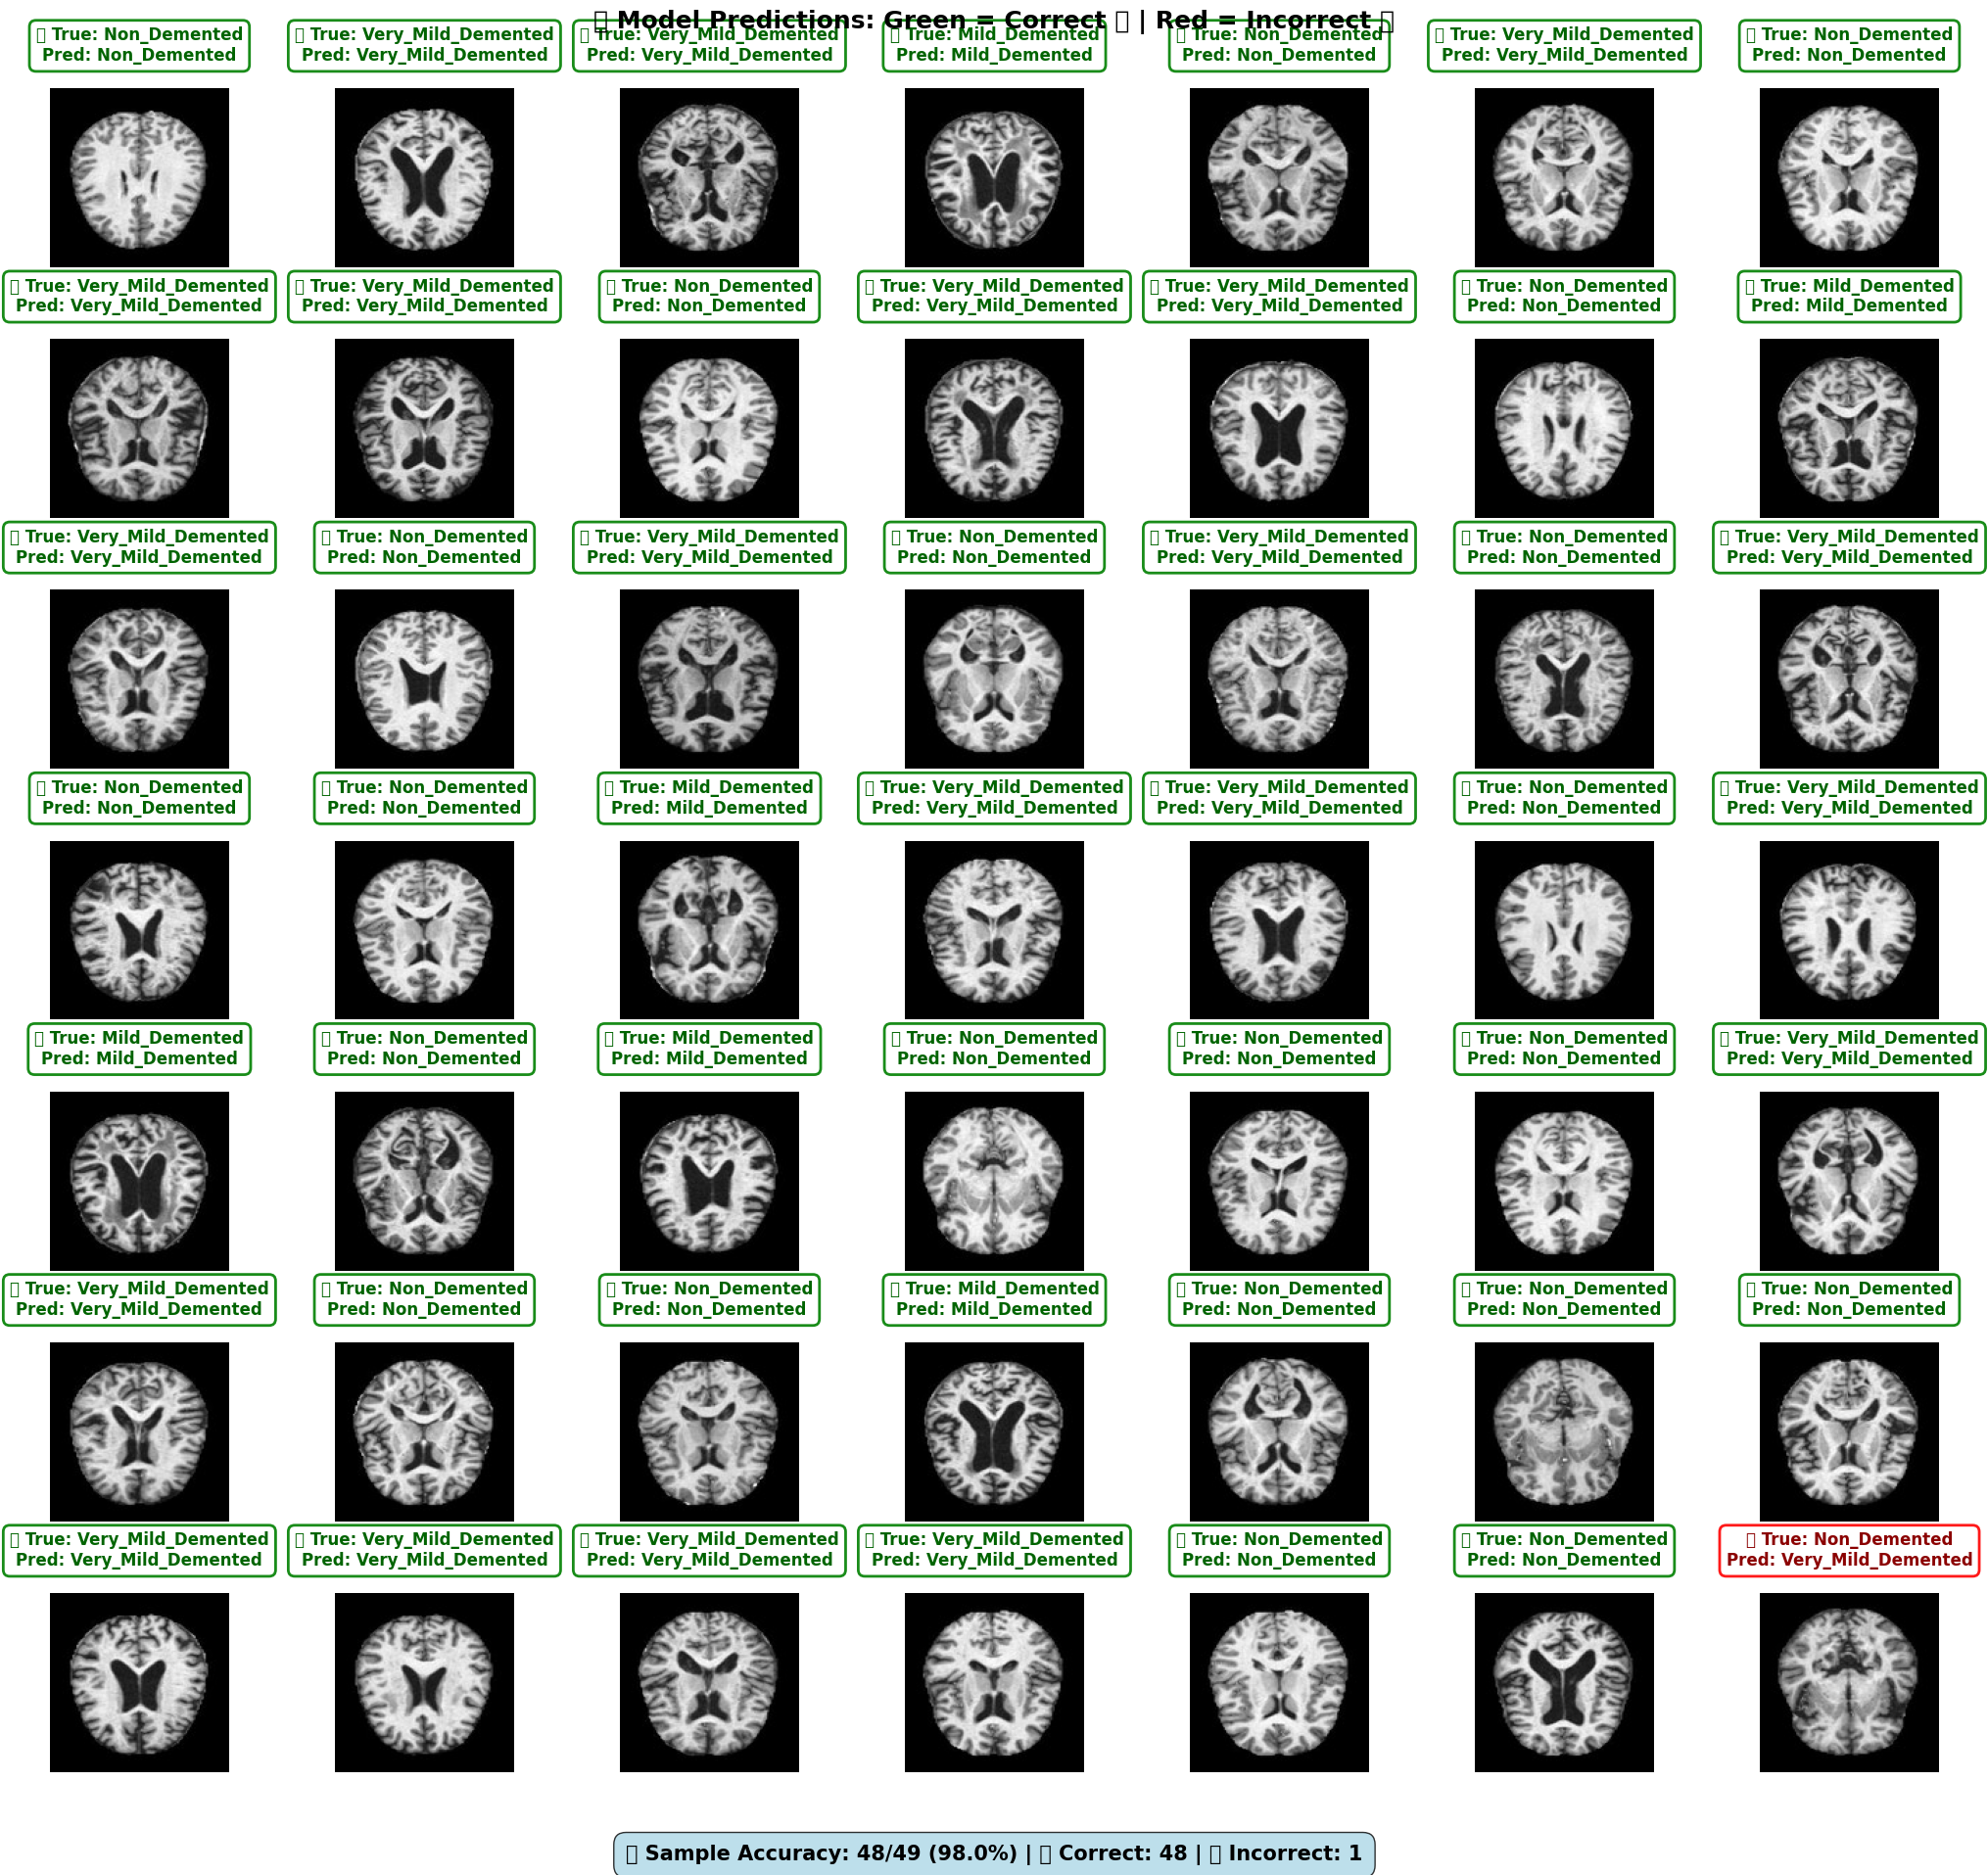


🎯 PREDICTION SUMMARY
✅ Correct predictions: 48/49 (98.0%)
❌ Incorrect predictions: 1/49 (2.0%)
🎲 Random sampling: New set shown every time you run this cell


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prédictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Détection automatique du format de y_val
if y_val.ndim > 1:
    y_true_classes = np.argmax(y_val, axis=1)
else:
    y_true_classes = y_val

# Sélection aléatoire de 49 images (no fixed seed)
indices = np.random.choice(X_val.shape[0], 49, replace=False)
selected_images      = X_val[indices]
selected_true_labels = y_true_classes[indices]
selected_pred_labels = y_pred_classes[indices]

# Affichage en grille 7×7 avec couleurs améliorées
fig, axes = plt.subplots(7, 7, figsize=(20, 20))
fig.suptitle('🎯 Model Predictions: Green = Correct ✅ | Red = Incorrect ❌',
             fontsize=18, fontweight='bold', y=0.96)

correct_count = 0

for ax, img, t, p in zip(axes.flat, selected_images, selected_true_labels, selected_pred_labels):
    if img.shape[-1] == 1:
        ax.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='gray')
    else:
        ax.imshow(img)

    is_correct = t == p
    if is_correct:
        correct_count += 1

    title_color = 'darkgreen' if is_correct else 'darkred'
    border_color = 'green' if is_correct else 'red'
    status_icon = '✅' if is_correct else '❌'

    title_text = f"{status_icon} True: {label_mapping[t]}\nPred: {label_mapping[p]}"

    ax.set_title(title_text, fontsize=12, fontweight='bold', color=title_color,
                bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                         edgecolor=border_color, linewidth=2, alpha=0.9),
                pad=20)

    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

    ax.axis('off')

# Summary below image grid
accuracy = correct_count / 49
fig.text(0.5, 0.015, f'📊 Sample Accuracy: {correct_count}/49 ({accuracy*100:.1f}%) | ✅ Correct: {correct_count} | ❌ Incorrect: {49-correct_count}',
         ha='center', fontsize=15, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.6", facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.06, hspace=0.4, wspace=0.3)
plt.show()

# Print stats
print(f"\n🎯 PREDICTION SUMMARY")
print(f"{'='*40}")
print(f"✅ Correct predictions: {correct_count}/49 ({accuracy*100:.1f}%)")
print(f"❌ Incorrect predictions: {49-correct_count}/49 ({(1-accuracy)*100:.1f}%)")
print(f"🎲 Random sampling: New set shown every time you run this cell")
print(f"{'='*40}")


**Graphical Representation of Everything **

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


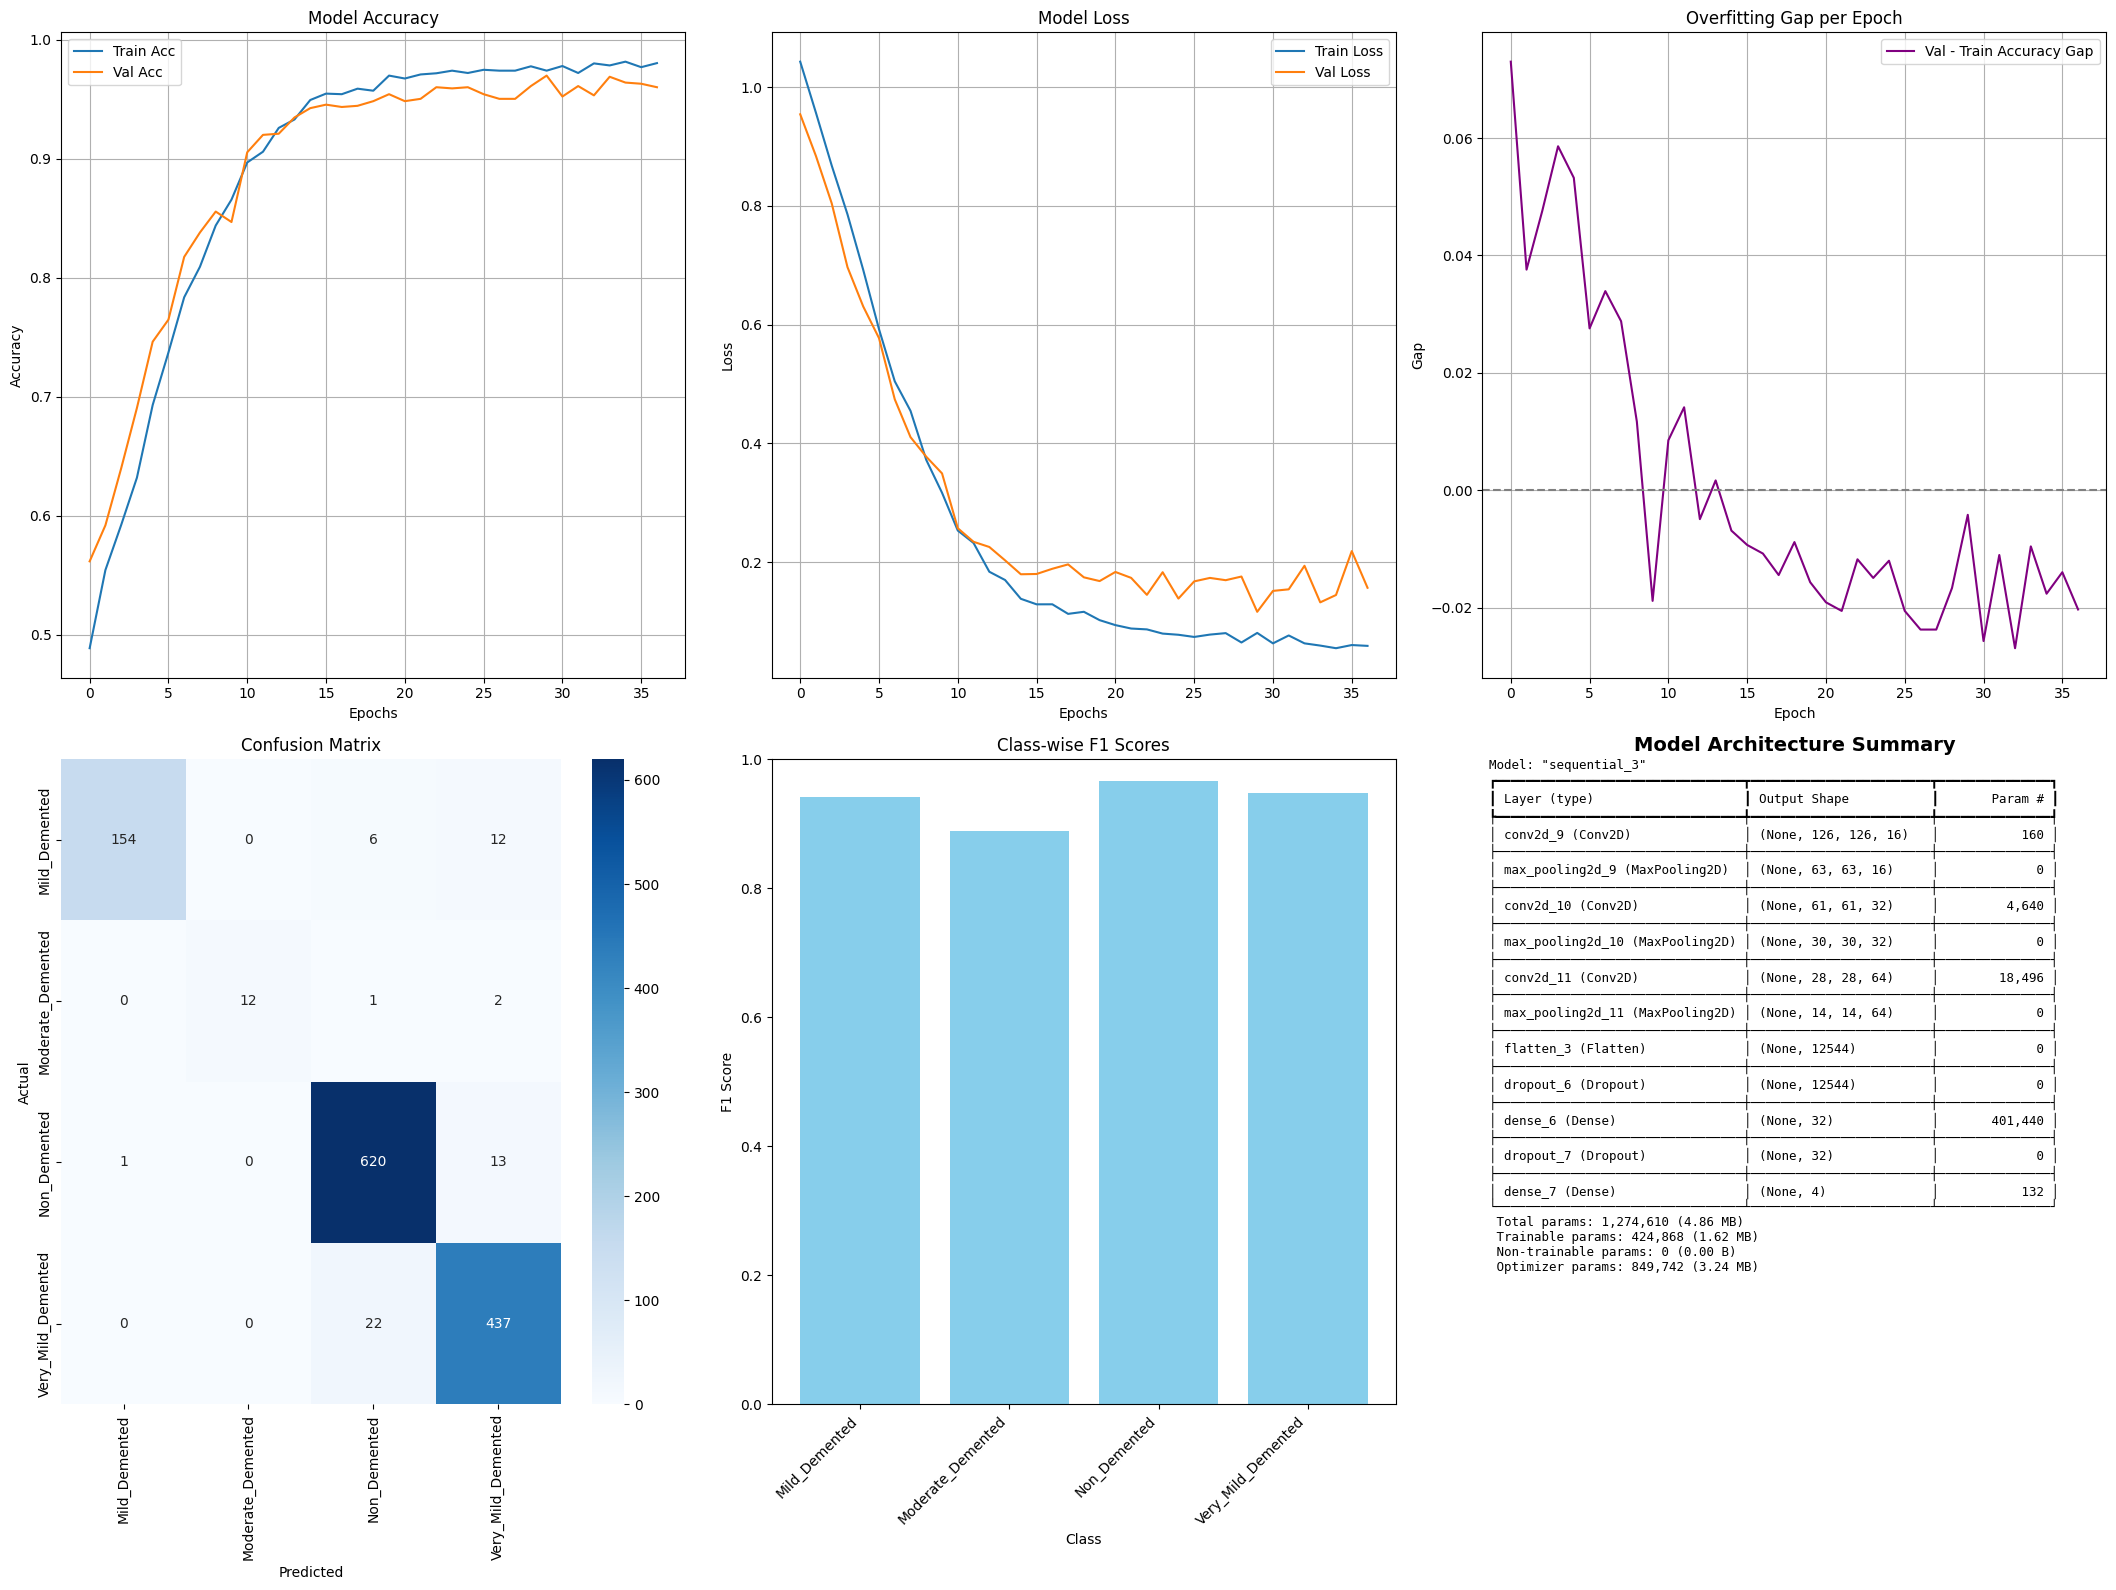

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Adjust the figure size
plt.figure(figsize=(22, 16))

# 1. Accuracy Curve
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# 2. Loss Curve
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Overfitting Gap
plt.subplot(2, 3, 3)
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
gap = val_acc - train_acc
plt.plot(gap, label='Val - Train Accuracy Gap', color='purple')
plt.title('Overfitting Gap per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Gap')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)

# 4. Confusion Matrix
plt.subplot(2, 3, 4)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# The error was here, y_test is already 1D
y_true = y_test # Corrected this line
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 5. Bar Chart of Class-wise F1-score
plt.subplot(2, 3, 5)
report = classification_report(y_true, y_pred_classes, output_dict=True)
# Extract F1 scores for each class, excluding overall metrics
class_names = [label_mapping[i] for i in sorted(label_mapping.keys())]
f1_scores = [report[str(i)]['f1-score'] for i in sorted(label_mapping.keys())]


plt.bar(class_names, f1_scores, color='skyblue')
plt.title('Class-wise F1 Scores')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # F1 score is between 0 and 1


# 6. Architecture Overview (Text only for visual placeholder)
plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Model Architecture Summary", fontsize=14, fontweight='bold')
# Capture model summary output
from io import StringIO
stringio = StringIO()
model.summary(print_fn=lambda x: stringio.write(x + '\n'))
summary_string = stringio.getvalue()
stringio.close()

plt.text(0.01, 1.0, summary_string, fontsize=9, va='top', family='monospace')

plt.tight_layout()
plt.show()